array([[<Axes: title={'center': 'i_f_goals'}>,
        <Axes: title={'center': 'i_f_points'}>],
       [<Axes: title={'center': 'i_f_hits'}>,
        <Axes: title={'center': 'penalityminutes'}>]], dtype=object)

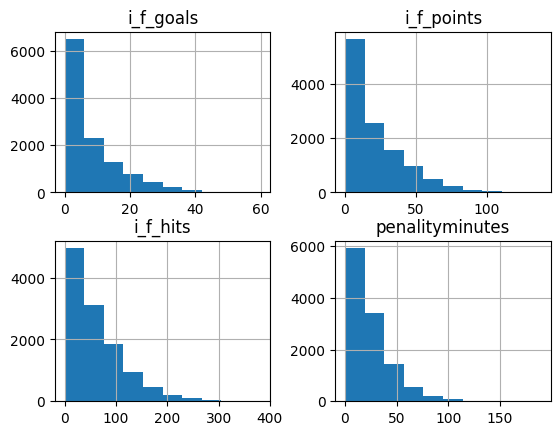

In [27]:
import pandas as pd
from matplotlib import pyplot as plt
import pymc as pm
import seaborn as sns
from pymc import distributions as d
import numpy as np
import arviz as az

df = pd.read_csv('./data/full_data.csv')
df = df.drop(columns = 'Team', axis=1)
# df = df[df['season'].astype(int) >= 2016]
df.columns = [col.lower() for col in df.columns]

df['salary'] = df['salary'].astype(float).transform('log')
df = df[df['salary'].notna()]

df[['i_f_goals', 'i_f_points', 'i_f_hits', 'penalityminutes']] = df[['i_f_goals', 'i_f_points', 'i_f_hits', 'penalityminutes']].astype('Int64')
df[['i_f_goals', 'i_f_points', 'i_f_hits', 'penalityminutes']].hist()


<Axes: xlabel='salary', ylabel='Count'>

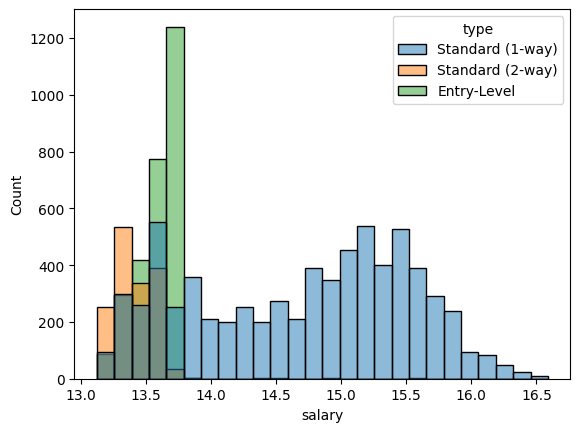

In [28]:
df = df[df['type'].isin(['Standard (1-way)', 'Standard (2-way)'])]
tmp_plot_data = df[df.type.isin(['Entry-Level', 'Standard (1-way)', 'Standard (2-way)'])]

sns.histplot(data = tmp_plot_data, x = 'salary', hue='type')


In [29]:
# df['type'] = df['type'].str.split(' ').apply(lambda x: x[0])
df = df[df['type'].isin(['Standard (1-way)', 'Standard (2-way)'])]

In [18]:
# df[df['season'] - 1 == df['contract_season']][['name', 'position', 'season', 'contract_season', 'signing date']]
df['season'].value_counts().sort_index()

season
2009    467
2010    510
2011    549
2012    558
2013    598
2014    628
2015    629
2016    613
2017    614
2018    625
2019    632
2020    680
2021    746
2022    697
Name: count, dtype: int64

In [19]:
df[['name', 'season', 'signing date']].sort_values(['name', 'season'])

,name,season,signing date
6184,A.J. Greer,2020,2020-10-21
6185,A.J. Greer,2021,2021-08-04
799,A.J. Greer,2022,2022-07-13
4637,Aaron Ekblad,2017,2016-07-01
4638,Aaron Ekblad,2018,2016-07-01
...,...,...,...
1576,Zemgus Girgensons,2017,2017-08-17
1577,Zemgus Girgensons,2018,2017-08-17
1578,Zemgus Girgensons,2019,2019-07-05
1579,Zemgus Girgensons,2021,2020-10-08


In [20]:
df.columns

Index(['unnamed: 0', 'team', 'merge_name', 'season', 'playerid', 'name',
       'position', 'games_played', 'icetime', 'shifts',
       'onice_xgoalspercentage', 'office_xgoalspercentage', 'penalties',
       'faceoffswon', 'penalityminutes', 'penalityminutesdrawn',
       'shotsblockedbyplayer', 'i_f_goals', 'i_f_primaryassists',
       'i_f_secondaryassists', 'i_f_points', 'i_f_hits', 'player', 'age',
       'weight', 'height', 'pos', 'type', 'extension', 'signing date',
       'signing age', 'clause', 'length', 'signing', 'expiry', 'exp. year',
       'cap hit', 'cap hit %', 'aav', 'salary', 'base salary', 's.bonus',
       'p.bonus', 'state/prov', 'country', 'conference', 'division', 'o6',
       'efftaxrate'],
      dtype='object')

<Axes: xlabel='position', ylabel='salary'>

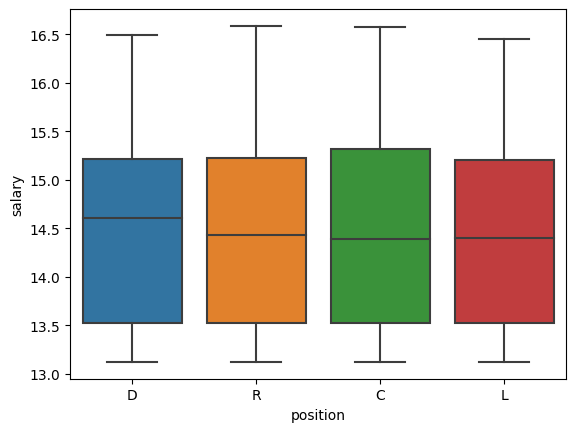

In [21]:
sns.boxplot(data=df, y = 'salary', x = 'position')

<Axes: xlabel='division', ylabel='salary'>

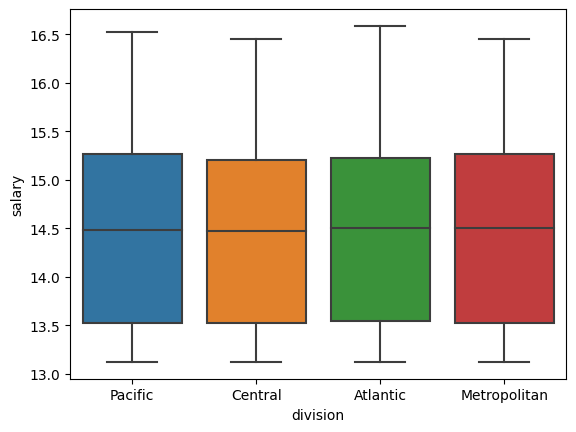

In [22]:
sns.boxplot(data=df, y = 'salary', x = 'division')

<Axes: xlabel='i_f_goals', ylabel='salary'>

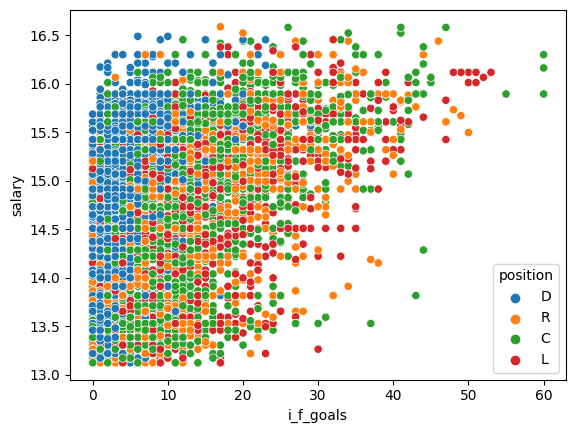

In [23]:
sns.scatterplot(data = df, x = 'i_f_goals', y = 'salary', hue = 'position')

In [24]:
df['clause'] = df['clause'].fillna('No Clause')

In [25]:
coords = {
    'team': df['team'].unique(),
    'players': df['name'].unique(),
    'position': df['position'].unique(),
    'conference': df['conference'].unique(),
    'division': df['division'].unique(),
    'country': df['country'].unique(),
    'state': df['state/prov'].unique(),
    'clause': df['clause'].isna(),
    'type': df['type'].unique(),
    'extension': df['extension'].unique()
}

player_coords = {
    col: pd.factorize(df[col])
    for col in ['conference', 'division', 'country', 'clause', 'type', 'extension', 'name', 'team', 'position', 'state/prov']
}

division_df = df[['division', 'team']].drop_duplicates().sort_values(['division', 'team'])
division_coords = {
    col: pd.factorize(division_df[col])
    for col in ['division', 'team']
}

coords = {
    'division': division_coords['division'][1].values,
    'team': division_coords['team'][1].values,
    'position': player_coords['position'][1].values,
    'clause': player_coords['clause'][1].values,
    'country': player_coords['country'][1].values,
    'type': player_coords['type'][1].values,
    'state': player_coords['state/prov'][1].values,
    'beta': ['Goals', 'Term']
}
print(coords)


{'division': array(['Atlantic', 'Central', 'Metropolitan', 'Pacific'], dtype=object), 'team': array(['BOS', 'BUF', 'DET', 'FLA', 'MTL', 'OTT', 'TBL', 'TOR', 'ARI',
       'CHI', 'COL', 'DAL', 'MIN', 'NSH', 'STL', 'WPG', 'CAR', 'CBJ',
       'NJD', 'NYI', 'NYR', 'PHI', 'PIT', 'WSH', 'ANA', 'CGY', 'EDM',
       'LAK', 'SEA', 'SJS', 'VAN', 'VGK'], dtype=object), 'position': array(['D', 'R', 'C', 'L'], dtype=object), 'clause': array(['No Clause', 'M-NTC', 'NTC', 'NMC', 'M-NTC, NMC', 'NTC, NMC',
       'M-NMC'], dtype=object), 'country': array(['USA', 'CA'], dtype=object), 'type': array(['Standard'], dtype=object), 'state': array(['CA', 'AZ', 'MA', 'NY', 'NC', 'OH', 'AB', 'IL', 'CO', 'TX', 'MI',
       'FL', 'MN', 'QC', 'NJ', 'TN', 'ON', 'PA', 'WA', 'MO', 'BC', 'NV',
       'MB', 'DC'], dtype=object), 'beta': ['Goals', 'Term']}


In [285]:
X = df[['if_goals', 'length']]
with pm.Model(coords=coords) as model:

    X = pm.Data('X', df[['i_f_goals', 'length']].astype(float).values)
    div_idx = pm.Data('div_idx', division_coords['division'][0])
    team_idx_p = pm.Data('team_idx_p', player_coords['team'][0])
    position_idx_p = pm.Data('position_idx_p', player_coords['position'][0])
    # X = df[['i_f_goals', 'length']].astype(int).values

    # data = pm.Data('data', df[['SALARY', 'team']])
    global_alpha = d.Normal('global_alpha', mu=13, sigma=3)
    div_alpha = d.Normal('div_alpha', global_alpha, 3, dims='division')
    team_alpha = d.Normal('team_alpha', div_alpha[div_idx], 1, dims='team')
    team_effect = team_alpha[team_idx_p]

    # global_player_stats_beta = d.Normal('global_player_stats', mu = 0, sigma = 2, shape=(3, ))
    pos_player_stats_beta = d.Normal('pos_player_stats', mu = 0, sigma = 2, dims=['position', 'beta'])
    # tmp = pm.draw(pos_player_stats_beta)

    # goals_beta = d.Normal('goals', mu=0, sigma=2, dims='position')
    # term_beta = d.Normal('term', mu=0, sigma=2, dims='position')
    # goal_term_interact = d.Normal('goal_term_interact', mu=0, sigma=2, dims='position')

    player_effects = (pos_player_stats_beta[position_idx_p] * X).sum(axis=1)
    # pos_player_stats_beta[player_coords['position'][0]] * df[['i_f_goals', 'length']].astype(int).values

    # goal_effect = goals_beta[player_coords['position'][0]] * df['i_f_goals'].astype(int).values
    # term_effect = term_beta[player_coords['position'][0]] * df['length'].astype(int).values
    # goal_term_effect = goal_term_interact[player_coords['position'][0]] * df['i_f_goals'].astype(int).values * df['length'].astype(int).values
    # player_effects = goal_effect + term_effect + goal_term_effect

    intercept = team_effect + player_effects
    salary_sigma = d.HalfNormal('salary_sigma', 2)
    # player_mu = intercept + player_effects 
    like = d.Normal('log_salary', mu=intercept, sigma=salary_sigma, observed=df['salary'].values)



/home/mcanearm/anaconda3/lib/python3.10/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [258]:


# np.tensordot(tmp, 5)
    # df[['i_f_goals', 'length']].dot(tmp[player_coords['position'][0]])

0        31.45323
1        31.45323
2        31.45323
3        31.45323
4       19.410138
          ...    
8118      3.47873
8119    -4.571143
8120    -4.571143
8124    -1.207796
8125    -3.214321
Length: 2619, dtype: object

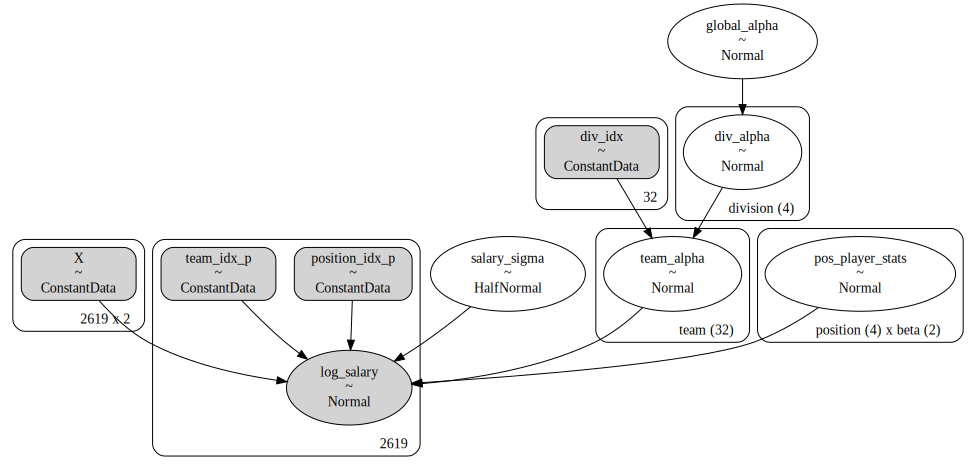

In [286]:
pm.model_to_graphviz(model)

In [290]:
from pymc.sampling_jax import sample_numpyro_nuts
with model:
    trace = pm.sample(1000, chains=4, progressbar=True)
    # trace = sample_numpyro_nuts(1000, chains=4, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha, div_alpha, team_alpha, pos_player_stats, salary_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


array([[<Axes: title={'center': 'global_alpha'}>,
        <Axes: title={'center': 'global_alpha'}>],
       [<Axes: title={'center': 'div_alpha'}>,
        <Axes: title={'center': 'div_alpha'}>],
       [<Axes: title={'center': 'team_alpha'}>,
        <Axes: title={'center': 'team_alpha'}>],
       [<Axes: title={'center': 'pos_player_stats'}>,
        <Axes: title={'center': 'pos_player_stats'}>],
       [<Axes: title={'center': 'salary_sigma'}>,
        <Axes: title={'center': 'salary_sigma'}>]], dtype=object)

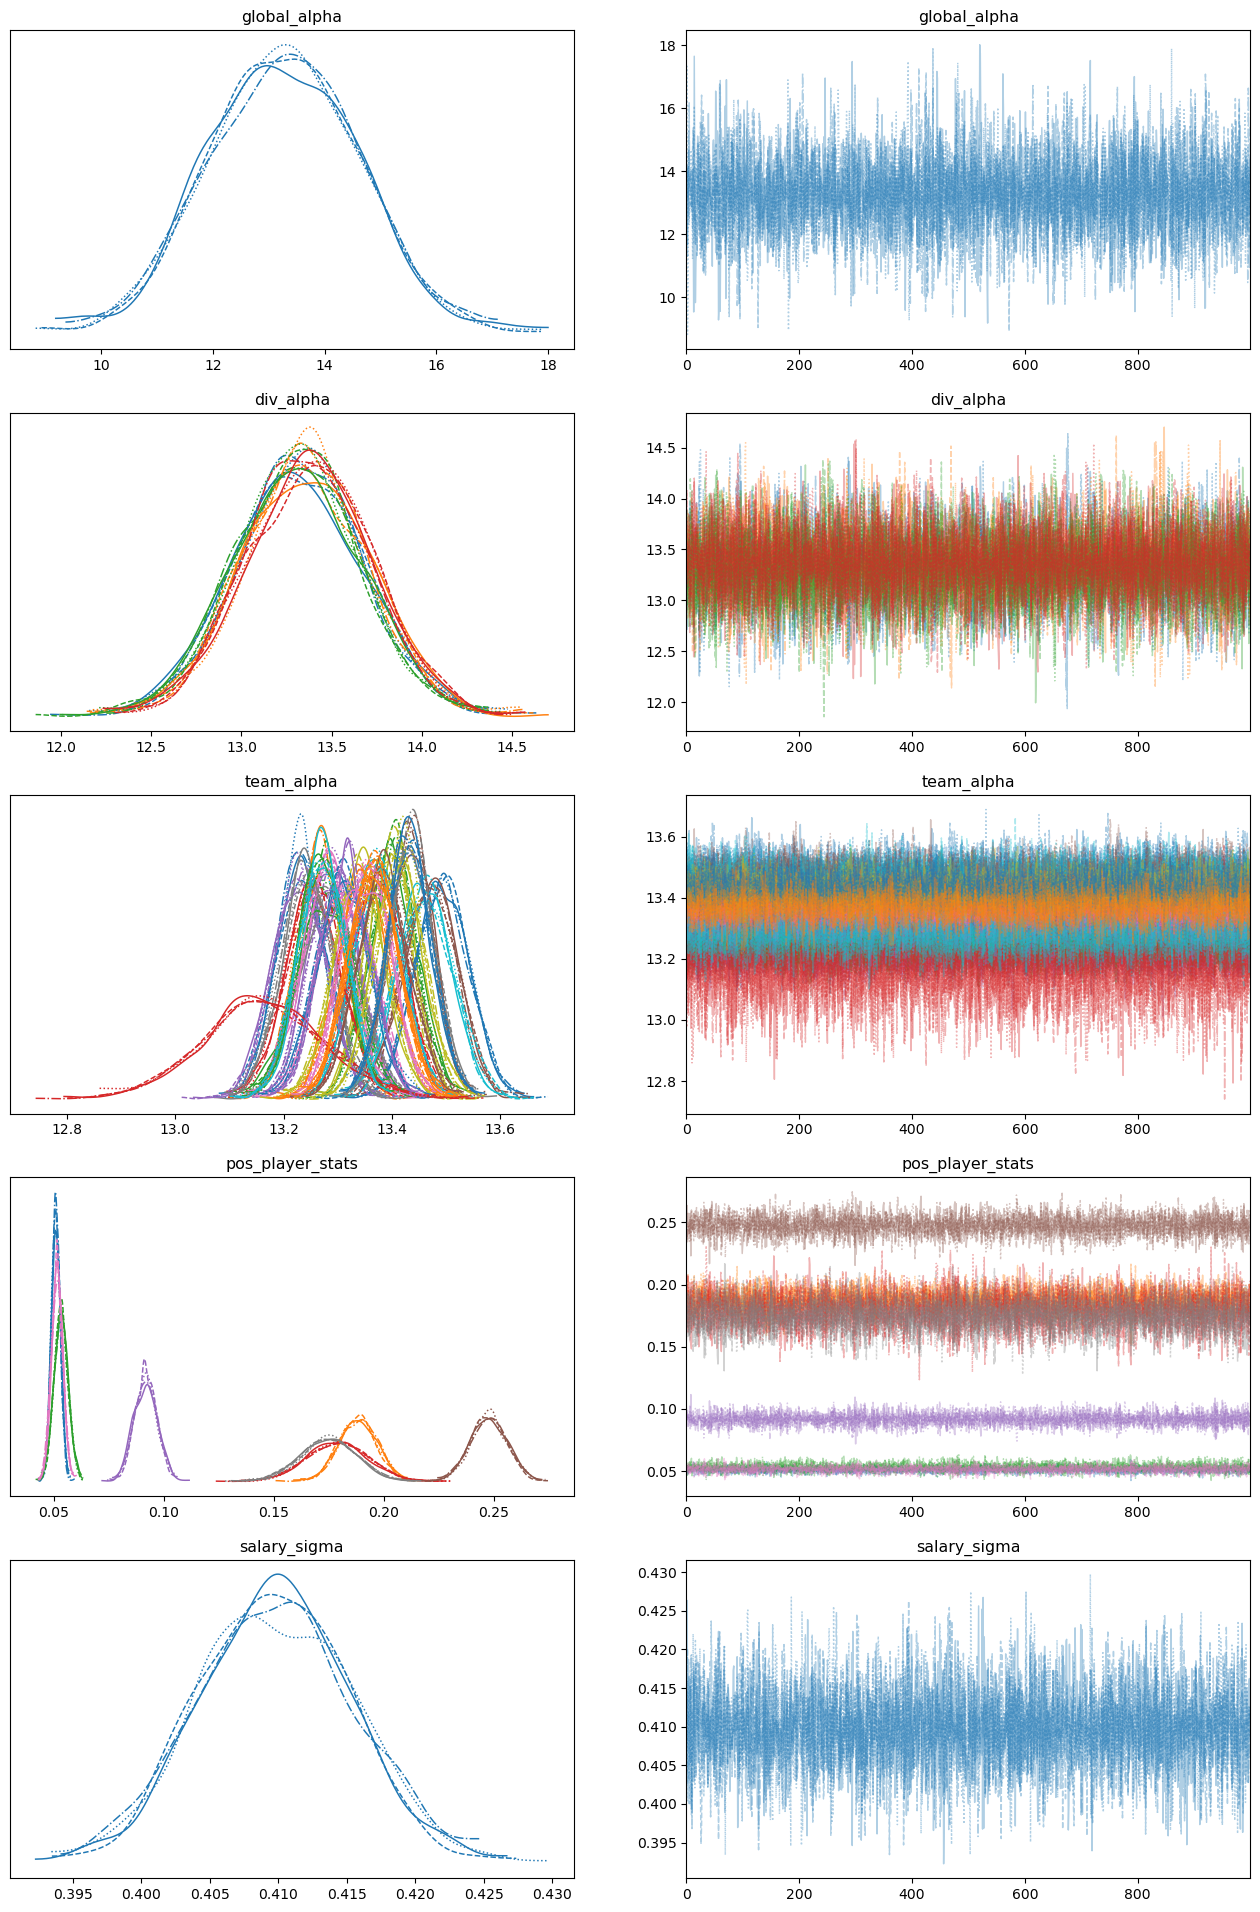

In [291]:
az.plot_trace(trace, figsize=(16, 24))

In [281]:
trace.posterior

<xarray.Dataset>
Dimensions:           (chain: 4, draw: 1000, division: 4, team: 32,
                       position: 4, beta: 2)
Coordinates:
  * chain             (chain) int64 0 1 2 3
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * division          (division) <U12 'Atlantic' 'Central' ... 'Pacific'
  * team              (team) <U3 'BOS' 'BUF' 'DET' 'FLA' ... 'SJS' 'VAN' 'VGK'
  * position          (position) <U1 'C' 'R' 'D' 'L'
  * beta              (beta) <U5 'Goals' 'Term'
Data variables:
    global_alpha      (chain, draw) float64 13.12 13.58 13.31 ... 12.86 13.84
    div_alpha         (chain, draw, division) float64 13.23 13.46 ... 13.47
    team_alpha        (chain, draw, team) float64 13.23 13.31 ... 13.37 13.31
    pos_player_stats  (chain, draw, position, beta) float64 0.05061 ... 0.1753
    salary_sigma      (chain, draw) float64 0.4061 0.4061 ... 0.4045 0.4143
Attributes:
    created_at:                 2023-04-12T03:54:46.359652
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.2.0
    sampling_time:              12.339111328125
    tuning_steps:               1000